# Explore and Process Data

## Load Data

In [1]:
# import useful libraries
import pandas as pd
import numpy as np
import scipy.stats as scs
from pathlib import Path
from sklearn.model_selection import train_test_split
%matplotlib inline
%pylab inline

# set the path of the raw data
raw_data_path = Path.cwd().parent / 'data' / 'raw' 
labeled_file_path = raw_data_path / 'train.csv'
unlabeled_file_path = raw_data_path / 'test.csv'

# read the data with all default parameters
labeled_df = pd.read_csv(labeled_file_path, index_col = 'PassengerId')
unlabeled_df = pd.read_csv(unlabeled_file_path, index_col = 'PassengerId')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# list columns, data types, and column counts
print('Labeled:\n')
print(labeled_df.info())
print('\nUnlabeled:\n')
print(unlabeled_df.info())

Labeled:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None

Unlabeled:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3)

## Labeled Data Survival Rate

In [3]:
print('Number of (labeled) passengers:', len(labeled_df))
print('Number of survivors:', len(labeled_df[labeled_df.Survived == 1]))
print('Survival rate:', labeled_df.Survived.mean())

Number of (labeled) passengers: 891
Number of survivors: 342
Survival rate: 0.3838383838383838


## Assumptions and Approach

We have both categorical and numerical data, and the standard approach is to one-hot encode categorical features. This means we will have many new columns, one for each value of a given categorical feature.

In order to decide whether or not to keep a given feature, F, we will look at the conditional probability of survival, S, given the value of the feature, P(S|F). There are three cases to keep in mind.

1. #(F) is small: In this case we want to see that P(S|F) is either very close to 0 (a small group of non-surivors) or 1 (a small group of survivors); otherwise it might be difficult for other features to help sort out survivors from non-survivors in such a small group. Note that !F ('not F', passengers without the feature) will have distribution close to that of the entire labeled data set, so we should expect to see P(S|!F) approximately 0.38.

2. #(F) is approximately 342, the total number of survivors: Of course, if we find P(S|F) very close to 1, then we have found most of the survivors with a single feature, which is unlikely. If P(S|F) is very close to 0, then we have found a big chunk of the non-survivors with a single feature, which should be helpful in avoiding false positives. Unlike the previous case (where #(F) is small), we can tolerate P(S|F) being not quite as close to the extremes, since other features can help us find survivors (if P(S|F) is closer to 1, non-surivors if closer to zero), perhaps in clusters. As for !F, we will find P(S|!F) ranging from 0 (if all/most of the survivors have F) to approximately 342/(891-342), or approximately 0.62.

3. #(F) is large: This is just the first case with the roles of F and !F reversed.

A final note: If we simply guess !S, we should have a classifier that is about 62% accurate. Therefore, any model that we construct should be able to beat this level of accuracy.

#### Missing Data: Age and Cabin in both sets. Embarked in labeled set and Fare in unlabeled set.

#### Numerical Data: Age, SibSp, Parch, and Fare

#### Categorical Data: Name, Sex, Ticket, Cabin, Embarked, Survived, Pclass

## Feature: Sex

In [4]:
# no missing values, so encode Sex as 1 if female, 0 if male
labeled_df['Sex_Female'] = labeled_df.Sex.map(lambda x : 1 if x == 'female' else 0)
unlabeled_df['Sex_Female'] = unlabeled_df.Sex.map(lambda x : 1 if x == 'female' else 0)

In [5]:
# let's look at the Sex_Female vs Survived crosstab...
ct = pd.crosstab(labeled_df.Sex_Female, labeled_df.Survived, margins = True)
print(ct, '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Sex_Female
print(labeled_df.groupby('Sex_Female').Survived.mean())

Survived      0    1  All
Sex_Female               
0           468  109  577
1            81  233  314
All         549  342  891 

Sex_Female
0    0.188908
1    0.742038
Name: Survived, dtype: float64


In [6]:
# delete Sex
labeled_df.drop(['Sex'], axis = 1, inplace = True)
unlabeled_df.drop(['Sex'], axis = 1, inplace = True)

We have found 233 of the 342 survivors with one feature, F = Sex_Female. Since #(F) is close to #(S), and P(S|F) ~ 0.74 is close to 1 (as close as we are likely to get with a single feature and #(F) ~ #(S)), we should defintely keep this feature. 

## Feature: Pclass

While Pclass is represented by an integer, it is ordinal data (e.g., the difference between Pclass = 1 and 2 is not exactly the same as the difference between Pclass = 2 and 3). So, we will one-hot encode Pclass.

In [7]:
# one-hot encode Pclass
labeled_df = pd.get_dummies(labeled_df, columns = ['Pclass'])
unlabeled_df = pd.get_dummies(unlabeled_df, columns = ['Pclass'])

In [8]:
# let's look at the Pclass_1 vs Survived crosstabs...
print(pd.crosstab(labeled_df.Pclass_1, labeled_df.Survived, margins = True), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Pclass_1
print(labeled_df.groupby('Pclass_1').Survived.mean(), '\n')

Survived    0    1  All
Pclass_1               
0         469  206  675
1          80  136  216
All       549  342  891 

Pclass_1
0    0.305185
1    0.629630
Name: Survived, dtype: float64 



In [9]:
# let's look at the Pclass_2 vs Survived crosstabs...
print(pd.crosstab(labeled_df.Pclass_2, labeled_df.Survived, margins = True), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Pclass_2
print(labeled_df.groupby('Pclass_2').Survived.mean(), '\n')

Survived    0    1  All
Pclass_2               
0         452  255  707
1          97   87  184
All       549  342  891 

Pclass_2
0    0.360679
1    0.472826
Name: Survived, dtype: float64 



In [10]:
# let's look at the Pclass_3 vs Survived crosstabs...
print(pd.crosstab(labeled_df.Pclass_3, labeled_df.Survived, margins = True), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Pclass_3
print(labeled_df.groupby('Pclass_3').Survived.mean(), '\n')

Survived    0    1  All
Pclass_3               
0         177  223  400
1         372  119  491
All       549  342  891 

Pclass_3
0    0.557500
1    0.242363
Name: Survived, dtype: float64 



Pclass_1: The size of this feature is not quite as large as that of Sex_Female, and P(S|F) is not quite has high, but still worth keeping.

Pclass_2: Even smaller than Pclass_1 and survival is about 50-50. The complement, !F, has distribution close to that of the entire labeled data set. We get to drop one of these features anyway (since any two determine the value of the third), so I think we should drop it.

Pclass_3: A relatively large feature with poor survival rate; its complement is also relatively large and has a survival rate of approximately 0.56. Not a great feature but good enough to keep for now, though other features will be needed to distinguish survivors from non-survivors.

In [11]:
# delete Pclass_2
labeled_df.drop(['Pclass_2'], axis = 1, inplace = True)
unlabeled_df.drop(['Pclass_2'], axis = 1, inplace = True)

## Feature: SibSp and Parch

These are numerical (ratio) data, so no need to one-hot encode unless we group values together.

In [12]:
# no missing values, so look at the Survived vs SibSp, Parch crosstabs
print(pd.crosstab([labeled_df.SibSp, labeled_df.Parch], labeled_df.Survived, margins = True), '\n')

# since these seem related, let's also look at a pivot table for
# SibSp (row) and Parch (column) with Survived totals and means
print(labeled_df.pivot_table(index = 'SibSp', columns = 'Parch', values = 'Survived',
                             aggfunc = mean, fill_value = 0))

Survived       0    1  All
SibSp Parch               
0     0      374  163  537
      1       13   25   38
      2        8   21   29
      3        0    1    1
      4        1    0    1
      5        2    0    2
1     0       59   64  123
      1       23   34   57
      2        7   12   19
      3        2    1    3
      4        3    0    3
      5        2    1    3
      6        1    0    1
2     0       12    4   16
      1        1    6    7
      2        2    2    4
      3        0    1    1
3     0        0    2    2
      1        7    0    7
      2        5    2    7
4     1        9    0    9
      2        6    3    9
5     2        5    0    5
8     2        7    0    7
All          549  342  891 

Parch         0         1         2         3  4         5  6
SibSp                                                        
0      0.303538  0.657895  0.724138  1.000000  0  0.000000  0
1      0.520325  0.596491  0.631579  0.333333  0  0.333333  0
2      0.250000  0.85

I'm not really sure what to think about these two features. The best I can come up with is the following: survival rate seems poor if both are zero (the passenger is traveling without relatives), or if their sum is greater than three (too many relatives to gather into a life boat?).

In [13]:
# determine whether or not the number of relatives is too small (zero) or too big (greater than three)
def get_support(sibsp, parch):
    return 1 if 1 <= sibsp + parch <= 3 else 0

# create new column
labeled_df['Small_Support'] = np.vectorize(get_support)(labeled_df['SibSp'],
                                                        labeled_df['Parch'])
unlabeled_df['Small_Support'] = np.vectorize(get_support)(unlabeled_df['SibSp'],
                                                          unlabeled_df['Parch'])

In [14]:
# let's look at the Small_Support vs Survived crosstabs...
print(pd.crosstab(labeled_df.Small_Support, labeled_df.Survived, margins = True), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Small_Support
print(labeled_df.groupby('Small_Support').Survived.mean(), '\n')

Survived         0    1  All
Small_Support               
0              426  173  599
1              123  169  292
All            549  342  891 

Small_Support
0    0.288815
1    0.578767
Name: Survived, dtype: float64 



Well, #(F) ~ #(S), but the survival rate isn't great. Stll, probably good enough to keep.

In [15]:
# drop SibSp and Parch
labeled_df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
unlabeled_df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

## Feature: Embarked

In [16]:
# we are only missing two values for Embarked, so let's take a look
labeled_df[labeled_df.Embarked.isnull()]

,Survived,Name,Age,Ticket,Fare,Cabin,Embarked,Sex_Female,Pclass_1,Pclass_3,Small_Support
PassengerId,,,,,,,,,,,
62,1,"Icard, Miss. Amelie",38.0,113572,80.0,B28,NaN,1,1,0,0
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0,113572,80.0,B28,NaN,1,1,0,0


Clearly these two were traveling together and had no other family on board, perhaps an elderly woman with her handmaid? In any case, I'm going to assume they have the same value of Embarked.

The most reasonable guess is probably the mode of Embarked. However, of all the other features, it seems like Pclass might be associated with Embarked, so let's also look at the mode of Embarked for the Pclass = 1 group.

In [17]:
# mode of Embarked
print('Mode of Embarked:')
print(labeled_df.Embarked.mode())

# they were in first class (Pclass = 1), so let's see the distribution of Embarked for Pclass = 1
print('\nDistribution of Embarked for Pclass = 1:')
print(labeled_df[labeled_df.Pclass_1 == 1].Embarked.value_counts())

Mode of Embarked:
0    S
dtype: object

Distribution of Embarked for Pclass = 1:
S    127
C     85
Q      2
Name: Embarked, dtype: int64


That settles it: we'll assume they embarked from S, then one-hot encode.

In [18]:
# replace nulls with S, the mode of Embarked
labeled_df.Embarked.fillna('S', inplace = True)
unlabeled_df.Embarked.fillna('S', inplace = True)

In [20]:
# one-hot encode
labeled_df = pd.get_dummies(labeled_df, columns = ['Embarked'])
unlabeled_df = pd.get_dummies(unlabeled_df, columns = ['Embarked'])

In [21]:
# let's look at the Embarked_C vs Survived crosstabs...
print(pd.crosstab(labeled_df.Embarked_C, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Embarked_C
print(labeled_df.groupby('Embarked_C').Survived.mean())

Survived      0    1
Embarked_C          
0           474  249
1            75   93 

Embarked_C
0    0.344398
1    0.553571
Name: Survived, dtype: float64


In [22]:
# let's look at the Embarked_Q vs Survived crosstabs...
print(pd.crosstab(labeled_df.Embarked_Q, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Embarked_Q
print(labeled_df.groupby('Embarked_Q').Survived.mean())

Survived      0    1
Embarked_Q          
0           502  312
1            47   30 

Embarked_Q
0    0.383292
1    0.389610
Name: Survived, dtype: float64


In [23]:
# let's look at the Embarked_S vs Survived crosstabs...
print(pd.crosstab(labeled_df.Embarked_S, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Embarked_S
print(labeled_df.groupby('Embarked_S').Survived.mean())

Survived      0    1
Embarked_S          
0           122  123
1           427  219 

Embarked_S
0    0.502041
1    0.339009
Name: Survived, dtype: float64


Embarked_Q is clearly worthless: the probability of survival, whether Embarked_Q is 0 or 1, is basically the same as the entire passenger set.

Embarked_S is not much better: poor surival rate if Embarked_S = 1, 50-50 chance if Embarked_S = 0.

Embarked_C is weakly associated with survival. I guess I'll keep it, though I doubt it will help much.

In [24]:
# delete Embarked_Q and Embarked_S
labeled_df.drop(['Embarked_Q', 'Embarked_S'], axis = 1, inplace = True)
unlabeled_df.drop(['Embarked_Q', 'Embarked_S'], axis = 1, inplace = True)

## Feature: Ticket

In [25]:
# how many distinct tickets are there?
labeled_df.Ticket.nunique()

681

In [26]:
labeled_df.Ticket.head(10)

PassengerId
1            A/5 21171
2             PC 17599
3     STON/O2. 3101282
4               113803
5               373450
6               330877
7                17463
8               349909
9               347742
10              237736
Name: Ticket, dtype: object

I have serious doubts that we can extract any information from Ticket that will predict Survived, so I'm going to just drop this column.

In [27]:
labeled_df.drop(['Ticket'], axis = 1, inplace = True)
unlabeled_df.drop(['Ticket'], axis = 1, inplace = True)

## Feature: Cabin

In [28]:
print('Cabins in labeled set:')
print(labeled_df.sort_values(by = 'Cabin')['Cabin'].unique())
print('\nCabins in unlabeled set:')
print(unlabeled_df.sort_values(by = 'Cabin')['Cabin'].unique())

Cabins in labeled set:
['A10' 'A14' 'A16' 'A19' 'A20' 'A23' 'A24' 'A26' 'A31' 'A32' 'A34' 'A36'
 'A5' 'A6' 'A7' 'B101' 'B102' 'B18' 'B19' 'B20' 'B22' 'B28' 'B3' 'B30'
 'B35' 'B37' 'B38' 'B39' 'B4' 'B41' 'B42' 'B49' 'B5' 'B50' 'B51 B53 B55'
 'B57 B59 B63 B66' 'B58 B60' 'B69' 'B71' 'B73' 'B77' 'B78' 'B79' 'B80'
 'B82 B84' 'B86' 'B94' 'B96 B98' 'C101' 'C103' 'C104' 'C106' 'C110' 'C111'
 'C118' 'C123' 'C124' 'C125' 'C126' 'C128' 'C148' 'C2' 'C22 C26'
 'C23 C25 C27' 'C30' 'C32' 'C45' 'C46' 'C47' 'C49' 'C50' 'C52' 'C54'
 'C62 C64' 'C65' 'C68' 'C7' 'C70' 'C78' 'C82' 'C83' 'C85' 'C86' 'C87'
 'C90' 'C91' 'C92' 'C93' 'C95' 'C99' 'D' 'D10 D12' 'D11' 'D15' 'D17' 'D19'
 'D20' 'D21' 'D26' 'D28' 'D30' 'D33' 'D35' 'D36' 'D37' 'D45' 'D46' 'D47'
 'D48' 'D49' 'D50' 'D56' 'D6' 'D7' 'D9' 'E10' 'E101' 'E12' 'E121' 'E17'
 'E24' 'E25' 'E31' 'E33' 'E34' 'E36' 'E38' 'E40' 'E44' 'E46' 'E49' 'E50'
 'E58' 'E63' 'E67' 'E68' 'E77' 'E8' 'F E69' 'F G63' 'F G73' 'F2' 'F33'
 'F38' 'F4' 'G6' 'T' nan]

Cabins in unlabeled

It looks like we have a letter (probably the deck) followed by a number (probably the room). I doubt the room number is useful, but maybe the deck letter will be. Let's extract the deck letter (and store it in the variable Deck), and replace NaN with U (for unknown).

In [29]:
def get_deck(cabin):
    return np.where(pd.notnull(cabin), str(cabin)[0].upper(), 'U')

labeled_df['Deck'] = labeled_df['Cabin'].map(get_deck)
unlabeled_df['Deck'] = unlabeled_df['Cabin'].map(get_deck)

In [30]:
# now let's look at the Deck vs Survived crosstab...
print(pd.crosstab(labeled_df.Deck, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Deck
print(labeled_df.groupby('Deck').Survived.mean())

Survived    0    1
Deck              
A           8    7
B          12   35
C          24   35
D           8   25
E           8   24
F           5    8
G           2    2
T           1    0
U         481  206 

Deck
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
U    0.299854
Name: Survived, dtype: float64


I'll skip the one-hot encoding this time and do the encoding myself based on the following observation: passengers in Decks B through F have a good survival rate, whereas Decks A, G, T, and Unknown have poor survival rate.

In [31]:
def get_deck_advantage(deck):
    bad_decks = ["A", "G", "T", "U"]
    return 0 if deck in bad_decks else 1

labeled_df['Deck_Advantage'] = labeled_df['Deck'].map(get_deck_advantage)
unlabeled_df['Deck_Advantage'] = unlabeled_df['Deck'].map(get_deck_advantage)

In [32]:
# now let's look at the Deck_Advantage vs Survived crosstab...
print(pd.crosstab(labeled_df.Deck_Advantage, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Deck_Advantage
print(labeled_df.groupby('Deck_Advantage').Survived.mean())

Survived          0    1
Deck_Advantage          
0               492  215
1                57  127 

Deck_Advantage
0    0.304102
1    0.690217
Name: Survived, dtype: float64


Well, #(F) is small, but surivaly rate is pretty good. Let's keep it.

In [33]:
# drop Cabin and Deck columns
labeled_df.drop(['Cabin', 'Deck'], axis = 1, inplace = True)
unlabeled_df.drop(['Cabin', 'Deck'], axis = 1, inplace = True)

## Feature: Name (and filling in missing Age values)

In [34]:
# take a look at Name format
labeled_df.Name.head(10)

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

It looks like each passenger has a title, which might give us some predictive power. With that said, a passenger's name is unlikely to be helpful, so let's extract the title and discard the name.

In [35]:
def get_title(name):
    first_name_with_title = name.split(',')[1]
    title = first_name_with_title.split('.')[0]
    title = title.strip().lower()
    return title

# how many of each title?
print('Titles in labeled set:')
print(labeled_df.Name.map(get_title).value_counts())
print('\nTitles in unlabeled set:')
print(unlabeled_df.Name.map(get_title).value_counts())

Titles in labeled set:
mr              517
miss            182
mrs             125
master           40
dr                7
rev               6
mlle              2
major             2
col               2
lady              1
jonkheer          1
ms                1
mme               1
capt              1
sir               1
don               1
the countess      1
Name: Name, dtype: int64

Titles in unlabeled set:
mr        240
miss       78
mrs        72
master     21
rev         2
col         2
ms          1
dr          1
dona        1
Name: Name, dtype: int64


In [36]:
# create Title column
labeled_df['Title'] = labeled_df.Name.map(get_title)
unlabeled_df['Title'] = unlabeled_df.Name.map(get_title)

Before we do anything else with Title, let's use it to fill in missing Age values. The idea is that a passenger's title might indicate age (e.g., master is likely to be younger than a mr).

We want to calculate the median Age by Title, then write a function to replace NaN with the appropriate median value. So let's see which values of Title we need to worry about.

In [37]:
df = labeled_df[labeled_df.Age.isnull()]
print('Titles for labeled passengers with missing Age:', df.Title.unique())

df = unlabeled_df[unlabeled_df.Age.isnull()]
print('Titles for unlabeled passengers with missing Age:', df.Title.unique())

Titles for labeled passengers with missing Age: ['mr' 'mrs' 'miss' 'master' 'dr']
Titles for unlabeled passengers with missing Age: ['mr' 'mrs' 'miss' 'ms' 'master']


Fortunately there aren't many, so I'll just write a simple function to handle this. I'm sure there is a nicer way to do this.

In [38]:
# create groups by Title and print median Age
labeled_df.groupby('Title').Age.median()

Title
capt            70.0
col             58.0
don             40.0
dr              46.5
jonkheer        38.0
lady            48.0
major           48.5
master           3.5
miss            21.0
mlle            24.0
mme             24.0
mr              30.0
mrs             35.0
ms              28.0
rev             46.5
sir             49.0
the countess    33.0
Name: Age, dtype: float64

In [39]:
def get_age(age, title):
    title_age_dict = {'mr' : 30.0, 'mrs' : 35.0, 'miss' : 21.0, 'master' : 3.5, 'dr' : 46.5, 'ms' : 28.0}
    return title_age_dict[title] if isnan(age) else age

In [40]:
# replace NaN in Age with corresponding group Age median
labeled_df['Age'] = np.vectorize(get_age)(labeled_df['Age'], labeled_df['Title'])
unlabeled_df['Age'] = np.vectorize(get_age)(unlabeled_df['Age'], unlabeled_df['Title'])

Now back to Title. We have too many values so we should try to group some of them together.

In [41]:
# let's look at the Title vs Survived crosstab...
print(pd.crosstab(labeled_df.Title, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Title
print(labeled_df.groupby('Title').Survived.mean())

Survived        0    1
Title                 
capt            1    0
col             1    1
don             1    0
dr              4    3
jonkheer        1    0
lady            0    1
major           1    1
master         17   23
miss           55  127
mlle            0    2
mme             0    1
mr            436   81
mrs            26   99
ms              0    1
rev             6    0
sir             0    1
the countess    0    1 

Title
capt            0.000000
col             0.500000
don             0.000000
dr              0.428571
jonkheer        0.000000
lady            1.000000
major           0.500000
master          0.575000
miss            0.697802
mlle            1.000000
mme             1.000000
mr              0.156673
mrs             0.792000
ms              1.000000
rev             0.000000
sir             1.000000
the countess    1.000000
Name: Survived, dtype: float64


Note that in 1912, Title would be indicate Sex, so I want to try to group these in such a way that we have some further stratification. Some titles indicate Age (e.g., Master is for young boys that aren't yet ready to be called Mr), others indicate royalty (e.g., Countess), etc.

I don't really have a lot of faith that Title adds anything, but I'll keep it for now with the following groups:

Elite: jonkheer, lady, sir, the countess, don, dona, capt, col, major, dr, rev 

Mr: mr

Mrs: mme, mrs, ms

Miss: miss, mlle

Master: master

Note: I wanted to further stratify Elite (e.g., Royal vs Professional), but this group is very small as it is. So it's basically an "other" category, which we will end up dropping anyway because of multicollinearity.

In [42]:
def get_title_group(title):
    title_group = {
        'capt' : 'Elite',
        'col' : 'Elite',
        'major' : 'Elite',
        'dr' : 'Elite',
        'jonkheer' : 'Elite',
        'lady' : 'Elite',
        'sir' : 'Elite',
        'the countess' : 'Elite',
        'don' : 'Elite',
        'dona' : 'Elite',
        'rev' : 'Elite',
        'mr' : 'Mr',
        'mme' : 'Mrs',
        'mrs' : 'Mrs',
        'ms' : 'Mrs',
        'miss' : 'Miss',
        'mlle' : 'Miss',
        'master' : 'Master'}
    return title_group[title]

# how many in each title group?
labeled_df.Title.map(get_title_group).value_counts()

Mr        517
Miss      184
Mrs       127
Master     40
Elite      23
Name: Title, dtype: int64

In [43]:
# create Status column (Status is short than Title_Group)
labeled_df['Status'] = labeled_df.Title.map(get_title_group)
unlabeled_df['Status'] = unlabeled_df.Title.map(get_title_group)

In [44]:
# let's look at the Status vs Survived crosstab...
print(pd.crosstab(labeled_df.Status, labeled_df.Survived, margins = True), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Status
print(labeled_df.groupby('Status').Survived.mean())

Survived    0    1  All
Status                 
Elite      15    8   23
Master     17   23   40
Miss       55  129  184
Mr        436   81  517
Mrs        26  101  127
All       549  342  891 

Status
Elite     0.347826
Master    0.575000
Miss      0.701087
Mr        0.156673
Mrs       0.795276
Name: Survived, dtype: float64


OK, good enough, so let's drop Name and Title, then one-hot encode Status.

In [45]:
# make sure we'll have the same set of columns after one-hot encoding
print(labeled_df.Status.unique())
print(unlabeled_df.Status.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Elite']
['Mr' 'Mrs' 'Miss' 'Master' 'Elite']


In [46]:
# one-hot encode
labeled_df = pd.get_dummies(labeled_df, columns = ['Status'])
unlabeled_df = pd.get_dummies(unlabeled_df, columns = ['Status'])

# drop Name and Title
labeled_df.drop(['Name', 'Title'], axis = 1, inplace = True)
unlabeled_df.drop(['Name', 'Title'], axis = 1, inplace = True)

In [47]:
# let's look at the Status_Mr vs Survived crosstabs...
print(pd.crosstab(labeled_df.Status_Mr, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Status_Mr
print(labeled_df.groupby('Status_Mr').Survived.mean())

Survived     0    1
Status_Mr          
0          113  261
1          436   81 

Status_Mr
0    0.697861
1    0.156673
Name: Survived, dtype: float64


In [48]:
# let's look at the Status_Mrs vs Survived crosstabs...
print(pd.crosstab(labeled_df.Status_Mrs, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Status_Mrs
print(labeled_df.groupby('Status_Mrs').Survived.mean())

Survived      0    1
Status_Mrs          
0           523  241
1            26  101 

Status_Mrs
0    0.315445
1    0.795276
Name: Survived, dtype: float64


In [49]:
# let's look at the Status_Miss vs Survived crosstabs...
print(pd.crosstab(labeled_df.Status_Miss, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Status_Miss
print(labeled_df.groupby('Status_Miss').Survived.mean())

Survived       0    1
Status_Miss          
0            494  213
1             55  129 

Status_Miss
0    0.301273
1    0.701087
Name: Survived, dtype: float64


In [50]:
# let's look at the Status_Master vs Survived crosstabs...
print(pd.crosstab(labeled_df.Status_Master, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Status_Master
print(labeled_df.groupby('Status_Master').Survived.mean())

Survived         0    1
Status_Master          
0              532  319
1               17   23 

Status_Master
0    0.374853
1    0.575000
Name: Survived, dtype: float64


In [51]:
# let's look at the Status_Elite vs Survived crosstabs...
print(pd.crosstab(labeled_df.Status_Elite, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Status_Elite
print(labeled_df.groupby('Status_Elite').Survived.mean())

Survived        0    1
Status_Elite          
0             534  334
1              15    8 

Status_Elite
0    0.384793
1    0.347826
Name: Survived, dtype: float64


As mentioned above, I'm not sure about these at all. Status_Mrs and Status_Miss are very similar to Sex_Female. Given that this is in 1912, I'm sure the overlap here is huge.

The distribution for Status_Master is different from Status_Mr, but Status_Master is a small group and doesn't have a great survival rate, while Status_Mr has a distribution that is very similar to !Sex_Female.

Finally, apparently being elite (how I've defined it) gives no advantage to survival.

I think I will drop all these columns after all!

In [52]:
# drop Name and Title
drop_cols = ['Status_Mr', 'Status_Mrs', 'Status_Miss', 'Status_Master', 'Status_Elite']
labeled_df.drop(drop_cols, axis = 1, inplace = True)
unlabeled_df.drop(drop_cols, axis = 1, inplace = True)

## Feature: Fare

In [53]:
# we are only missing one value of Fare in the unlabeled data
unlabeled_df[unlabeled_df.Fare.isnull()]

,Age,Fare,Sex_Female,Pclass_1,Pclass_3,Small_Support,Embarked_C,Deck_Advantage
PassengerId,,,,,,,,
1044,60.5,NaN,0,0,1,0,0,0


In [54]:
# this passenger is male and in Pclass_3, so let's impute with the median Fare value for this group
m = labeled_df[(labeled_df.Sex_Female == 0) & (labeled_df.Pclass_3 == 1)].Fare.median()
unlabeled_df.Fare.fillna(m, inplace = True)

Fare is a continuous variable, so we should look at its distribution and consider rescaling and/or binning.

In [55]:
# summary statistics
labeled_df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

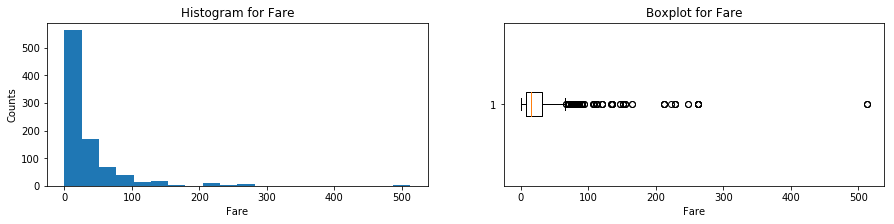

In [56]:
# histogram and boxplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 3))

ax1.hist(labeled_df.Fare, bins = 20)
ax1.set_title('Histogram for Fare')
ax1.set_xlabel('Fare')
ax1.set_ylabel('Counts')

ax2.boxplot(labeled_df.Fare, vert = False)
ax2.set_title('Boxplot for Fare')
ax2.set_xlabel('Fare')

plt.show()

Lots of outliers, so let's bin Fare using percentiles.

In [58]:
# let's cut Fare up into thirds
num_of_bins = 3
labeled_df['Fare_Bin'] = pd.qcut(labeled_df.Fare, num_of_bins, labels = range(num_of_bins))

In [59]:
# let's look at the Fare_Bin vs Survived crosstab...
ct = pd.crosstab(labeled_df.Fare_Bin, labeled_df.Survived, margins = True)
print(ct, '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Fare_Bin
print(labeled_df.groupby('Fare_Bin').Survived.mean())

Survived    0    1  All
Fare_Bin               
0         247   61  308
2         172  116  288
1         130  165  295
All       549  342  891 

Fare_Bin
0    0.198052
1    0.402778
2    0.559322
Name: Survived, dtype: float64


These bins have somewate distinct survival rates (one is poor, one that is similar to the entire passeger set, and one is a bit better than 50-50), and we don't want to greatly increase the number of features, so let's stick with thirds.

In [60]:
# function to convert Fare into bins (need for unlabeled data)
c1 = np.percentile(labeled_df.Fare, 33)
c2 = np.percentile(labeled_df.Fare, 66)

def get_fare_bin(fare):
    if fare < c1:
        return 0
    elif fare < c2:
        return 1
    else:
        return 2

In [61]:
# using one- and two-third cuts from labeled data, create Fare_Bin in unlabeled data
unlabeled_df['Fare_Bin'] = unlabeled_df.Fare.map(get_fare_bin)

# one-hot encode
labeled_df = pd.get_dummies(labeled_df, columns = ['Fare_Bin'])
unlabeled_df = pd.get_dummies(unlabeled_df, columns = ['Fare_Bin'])

In [62]:
# let's look at the Fare_Bin_0 vs Survived crosstabs...
print(pd.crosstab(labeled_df.Fare_Bin_0, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Fare_Bin_0
print(labeled_df.groupby('Fare_Bin_0').Survived.mean())

Survived      0    1
Fare_Bin_0          
0           302  281
1           247   61 

Fare_Bin_0
0    0.481990
1    0.198052
Name: Survived, dtype: float64


In [63]:
# let's look at the Fare_Bin_1 vs Survived crosstabs...
print(pd.crosstab(labeled_df.Fare_Bin_1, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Fare_Bin_1
print(labeled_df.groupby('Fare_Bin_1').Survived.mean())

Survived      0    1
Fare_Bin_1          
0           377  226
1           172  116 

Fare_Bin_1
0    0.374793
1    0.402778
Name: Survived, dtype: float64


In [64]:
# let's look at the Fare_Bin_2 vs Survived crosstabs...
print(pd.crosstab(labeled_df.Fare_Bin_2, labeled_df.Survived), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Fare_Bin_2
print(labeled_df.groupby('Fare_Bin_2').Survived.mean())

Survived      0    1
Fare_Bin_2          
0           419  177
1           130  165 

Fare_Bin_2
0    0.296980
1    0.559322
Name: Survived, dtype: float64


Another not-great feature. Fare_Bin_0 is strongly associated with non-survival, but Fare_Bin_2 is only weakly associated with survival. Fare_Bin_1 can be dropped since we get to drop one anyway.

In [65]:
# can drop Fare and Fare_Bin_1
labeled_df.drop(['Fare', 'Fare_Bin_1'], axis = 1, inplace = True)
unlabeled_df.drop(['Fare', 'Fare_Bin_1'], axis = 1, inplace = True)

## Feature: Age

Fare is a continuous variable, so we should look at its distribution and consider rescaling and/or binning.

In [66]:
# summary statistics
labeled_df.Age.describe()

count    891.000000
mean      29.390202
std       13.265322
min        0.420000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

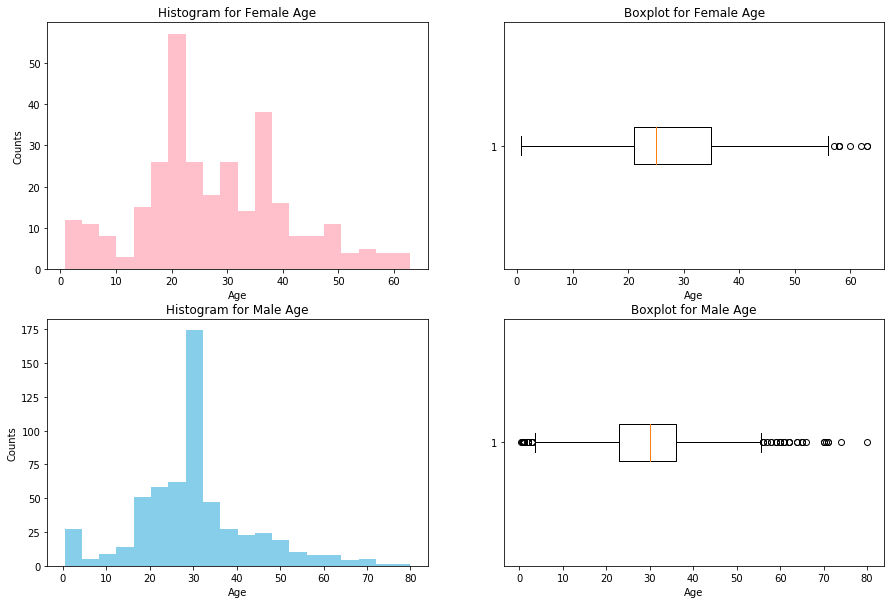

In [67]:
# histogram and boxplot
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 10))

ax1.hist(labeled_df[labeled_df.Sex_Female == 1].Age, bins = 20, color = 'pink')
ax1.set_title('Histogram for Female Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Counts')

ax2.boxplot(labeled_df[labeled_df.Sex_Female == 1].Age, vert = False)
ax2.set_title('Boxplot for Female Age')
ax2.set_xlabel('Age')

ax3.hist(labeled_df[labeled_df.Sex_Female == 0].Age, bins = 20, color = 'skyblue')
ax3.set_title('Histogram for Male Age')
ax3.set_xlabel('Age')
ax3.set_ylabel('Counts')

ax4.boxplot(labeled_df[labeled_df.Sex_Female == 0].Age, vert = False)
ax4.set_title('Boxplot for Male Age')
ax4.set_xlabel('Age')

plt.show()

Not as bad as Fare, but we still have some outliers. I'm going to assume that beyond a certain age, a passenger's age doesn't really determine survival; and that below that cut-off, the passenger is young enough that someone would be helping him or her survive.

In [68]:
# look at the proportion of passengers of Age < i that survived
# for i from 1..Age.max()
for i in range(1, 1 + int(labeled_df.Age.max())):
    print(i, " ", labeled_df[labeled_df.Age < i].Survived.mean())

1   1.0
2   0.8571428571428571
3   0.625
4   0.6470588235294118
5   0.6590909090909091
6   0.6875
7   0.6862745098039216
8   0.6666666666666666
9   0.6551724137931034
10   0.6060606060606061
11   0.5882352941176471
12   0.5694444444444444
13   0.5753424657534246
14   0.5866666666666667
15   0.573170731707317
16   0.5862068965517241
17   0.5480769230769231
18   0.5384615384615384
19   0.5034965034965035
20   0.48214285714285715
21   0.45652173913043476
22   0.45491803278688525
23   0.45018450184501846
24   0.4425087108013937
25   0.44654088050314467
26   0.4340175953079179
27   0.42896935933147634
28   0.4376657824933687
29   0.42574257425742573
30   0.42452830188679247
31   0.35789473684210527
32   0.36115843270868825
33   0.3657331136738056
34   0.3665594855305466
35   0.3667711598746082
36   0.3848439821693908
37   0.3879310344827586
38   0.38603988603988604
39   0.3870967741935484
40   0.38651994497936726
41   0.3867924528301887
42   0.38636363636363635
43   0.3876478318002628
44   

It looks like if a passenger is younger than 10 years old, there is about a 0.66 chance of survival. I'll create a new column called Helpless.

In [69]:
# replace Age with a category that takes 1 if Age < 10; 0 otherwise (including nulls, since unlikely Age < 10)
def is_helpless(x):
    return 0 if (x >= 10.0 or pd.isna(x)) else 1

# create the new column
labeled_df['Helpless'] = labeled_df.Age.map(lambda x : is_helpless(x))
unlabeled_df['Helpless'] = unlabeled_df.Age.map(lambda x : is_helpless(x))

In [70]:
# let's look at the Helpless vs Survived crosstabs...
print(pd.crosstab(labeled_df.Helpless, labeled_df.Survived, margins = True), '\n')

# ...as well as the mean Survived (proportion that survived) grouping by Helpless
print(labeled_df.groupby('Helpless').Survived.mean())

Survived    0    1  All
Helpless               
0         523  302  825
1          26   40   66
All       549  342  891 

Helpless
0    0.366061
1    0.606061
Name: Survived, dtype: float64


Helpless is a small group and the survival rate isn't great, but maybe it can help out a little bit.

In [71]:
# can drop Age
labeled_df.drop(['Age'], axis = 1, inplace = True)
unlabeled_df.drop(['Age'], axis = 1, inplace = True)

## Final Check

In [72]:
# check if any nulls remain
print(labeled_df.isnull().any().any(), '\n')
print(unlabeled_df.isnull().any().any())

False 

False


In [73]:
# all columns should be numeric
print(labeled_df.info(), '\n')
print(unlabeled_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Survived          891 non-null int64
Sex_Female        891 non-null int64
Pclass_1          891 non-null uint8
Pclass_3          891 non-null uint8
Small_Support     891 non-null int64
Embarked_C        891 non-null uint8
Deck_Advantage    891 non-null int64
Fare_Bin_0        891 non-null uint8
Fare_Bin_2        891 non-null uint8
Helpless          891 non-null int64
dtypes: int64(5), uint8(5)
memory usage: 46.1 KB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
Sex_Female        418 non-null int64
Pclass_1          418 non-null uint8
Pclass_3          418 non-null uint8
Small_Support     418 non-null int64
Embarked_C        418 non-null uint8
Deck_Advantage    418 non-null int64
Fare_Bin_0        418 non-null uint8
Fare_Bin_2        418 non-null uint8
Helpless          418 non-null int64
dtypes: int64(4), uint8(5)
me

In [74]:
# sort columns alphabetically then put Survived as the first column
columns = [column for column in labeled_df.columns if column != 'Survived']
columns = ['Survived'] + sorted(columns)
labeled_df = labeled_df[columns]

columns = unlabeled_df.columns
columns = sorted(columns)
unlabeled_df = unlabeled_df[columns]

In [75]:
# all check the column sort
print(labeled_df.columns, '\n')
print(unlabeled_df.columns)

Index(['Survived', 'Deck_Advantage', 'Embarked_C', 'Fare_Bin_0', 'Fare_Bin_2',
       'Helpless', 'Pclass_1', 'Pclass_3', 'Sex_Female', 'Small_Support'],
      dtype='object') 

Index(['Deck_Advantage', 'Embarked_C', 'Fare_Bin_0', 'Fare_Bin_2', 'Helpless',
       'Pclass_1', 'Pclass_3', 'Sex_Female', 'Small_Support'],
      dtype='object')


In [76]:
# a look at correlation matrix
corr = labeled_df.corr()
corr.style.background_gradient()

,Survived,Deck_Advantage,Embarked_C,Fare_Bin_0,Fare_Bin_2,Helpless,Pclass_1,Pclass_3,Sex_Female,Small_Support
Survived,1,0.321393,0.16824,-0.277673,0.253865,0.129244,0.285904,-0.322308,0.543351,0.279855
Deck_Advantage,0.321393,1,0.193553,-0.324163,0.560161,-0.0701858,0.746558,-0.520616,0.157606,0.216776
Embarked_C,0.16824,0.193553,1,-0.133176,0.22789,-0.0158254,0.296423,-0.153329,0.0828535,0.158586
Fare_Bin_0,-0.277673,-0.324163,-0.133176,1,-0.511363,-0.196572,-0.378125,0.599105,-0.269436,-0.406928
Fare_Bin_2,0.253865,0.560161,0.22789,-0.511363,1,0.110625,0.737278,-0.530138,0.13498,0.204872
Helpless,0.129244,-0.0701858,-0.0158254,-0.196572,0.110625,1,-0.13,0.0829693,0.0604691,0.167723
Pclass_1,0.285904,0.746558,0.296423,-0.378125,0.737278,-0.13,1,-0.626738,0.0980131,0.168568
Pclass_3,-0.322308,-0.520616,-0.153329,0.599105,-0.530138,0.0829693,-0.626738,1,-0.137143,-0.230325
Sex_Female,0.543351,0.157606,0.0828535,-0.269436,0.13498,0.0604691,0.0980131,-0.137143,1,0.260747
Small_Support,0.279855,0.216776,0.158586,-0.406928,0.204872,0.167723,0.168568,-0.230325,0.260747,1


## Split Labeled Data into Train and Test Sets

In [77]:
# train on 80%, test on 20%
# stratify split based on Survived column
train_df, test_df = train_test_split(labeled_df,
                                     test_size = 0.2,
                                     random_state = 42,
                                     stratify = labeled_df.Survived)
print(labeled_df.shape, " = ", train_df.shape, " + ", test_df.shape)
print(unlabeled_df.shape)

(891, 10)  =  (712, 10)  +  (179, 10)
(418, 9)


In [78]:
# make sure stratification is good
print(train_df.Survived.value_counts() / len(train_df), '\n')
print(test_df.Survived.value_counts() / len(test_df))

0    0.616573
1    0.383427
Name: Survived, dtype: float64 

0    0.614525
1    0.385475
Name: Survived, dtype: float64


## Save Processed Data

In [79]:
# define file paths
processed_data_path = Path.cwd().parent / 'data' / 'processed'
write_train_processed_path = processed_data_path / 'train_processed_cp.csv'
write_test_processed_path = processed_data_path / 'test_processed_cp.csv'
write_unlabeled_processed_path = processed_data_path / 'unlabeled_processed_cp.csv'

In [80]:
# write files
train_df.to_csv(write_train_processed_path)
test_df.to_csv(write_test_processed_path)
unlabeled_df.to_csv(write_unlabeled_processed_path)

I should write a processing script like I did for the MNIST digit recognizer. I'll circle back and do that later, promise!